# K Means clustering
This notebook follows closely [Lesson 12](https://github.com/fastai/course22p2/blob/master/nbs/02_meanshift.ipynb) of Practical Deep Learning for Coders. The goal is to implement a clustering algorithm from scratch so that we can truly understand it.

In the lesson notebook, Jeremy implemented the meanshift algorithm. I have decided to implement the k-means algorithm instead as it is commonly used/taught in schools.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters = 6
n_samples = 250

We are going to create 6 clusters, and each cluster has 250 points around it.

In [11]:
# multiply by 2 as there are 2 dimensions
centroids = torch.rand(n_clusters, 2) * 100 - 50

In [12]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [13]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [14]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices) # we want to work in Tensors
data.shape

torch.Size([1500, 2])

Let's write a helper function to plot the data. Each centroid will be marked with X, while each clustering will have an associated color.

In [15]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5, marker="X", color="m", mew=2)

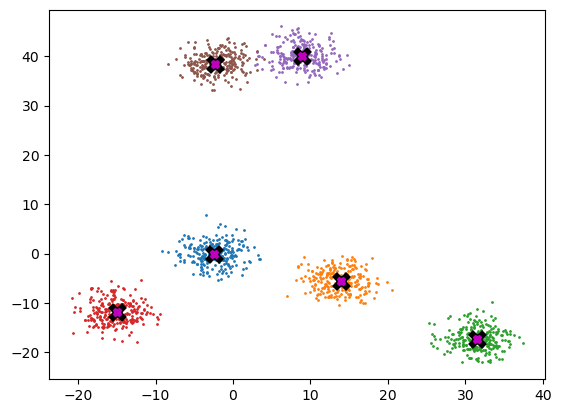

In [16]:
plot_data(centroids, data, n_samples)

## K-means algorithm
K-means is a well-known clustering algorithm. Its pseudo-code works as follows:

Inputs:
- K: number of clusters
- data: set of data points

Algorithm:
1. Initialise `K` centroids randomly by assiging a random data point as a centroid's coordinates.
2. Repeat until convergence:
- Assign each data point to the nearest centroid
- Update centroids using the assigned data points.
- Check for convergence
3. Output final clusters and centroids

In [18]:
data

tensor([[-0.182,  0.762],
        [ 0.052,  0.233],
        [-4.655, -2.035],
        ...,
        [-2.815, 38.784],
        [-6.889, 41.767],
        [-2.201, 38.495]])

In [20]:
random_indices = torch.randperm(data.size(0))[:n_clusters]
kmeans_centroids = data[random_indices]
kmeans_centroids

tensor([[ 15.817,  -8.729],
        [-14.312, -15.061],
        [  0.741,   1.943],
        [-16.476, -11.341],
        [-14.361, -17.789],
        [ 15.037,  -3.490]])

Our next step is to find out how to implement a L2 norm for each data point and each of the centroids so that we can assign them accordingly.

In [21]:
X = data.clone()
x = X[0]
x

tensor([-0.182,  0.762])

In [22]:
x.shape, kmeans_centroids.shape

(torch.Size([2]), torch.Size([6, 2]))

In [23]:
x[None,:].shape, kmeans_centroids.shape

(torch.Size([1, 2]), torch.Size([6, 2]))

In [28]:
dist = torch.einsum('ij->i', ((x - kmeans_centroids)**2)).sqrt()
dist

tensor([18.602, 21.213,  1.500, 20.296, 23.349, 15.803])

In [29]:
torch.argmin(dist)

tensor(2)

In [40]:
point_indices = torch.zeros((n_clusters*n_samples), dtype=torch.uint8)
point_indices.shape

torch.Size([1500])

In [41]:
point_indices[0] = torch.argmin(dist)
point_indices[0]

tensor(2, dtype=torch.uint8)

In [42]:
data[point_indices == 2]

tensor([[-0.182,  0.762]])

Ok, now we can start putting these steps together into a single function that expresses a single step in the k-means algorithm.

In [43]:
def one_update(X, kmeans_centroids):
    point_indices = torch.zeros((n_clusters*n_samples), dtype=torch.uint8)
    for i, x in enumerate(X):
        # assign each data point to nearest centroid
        dist = torch.einsum('ij->i', ((x - kmeans_centroids)**2)).sqrt()
        point_indices[i] = torch.argmin(dist)

    # re-calculate new kmeans centroid
    updated_kmeans_centroids = torch.zeros(kmeans_centroids.shape)
    for i in range(n_clusters):
        updated_kmeans_centroids[i] = torch.mean(X[point_indices==i], dim=0)

    return updated_kmeans_centroids

In [44]:
updated_kmeans_centroids = one_update(X, kmeans_centroids)
updated_kmeans_centroids

tensor([[ 26.868, -14.664],
        [-13.966, -13.666],
        [  1.416,  26.291],
        [-15.836, -10.750],
        [-14.494, -17.357],
        [ 13.308,  -4.113]])

I'm not entirely sure if this is working correctly, time it, then plot it to see where the centroids end up at.

In [50]:
def kmeans(X):
    # init centroids
    random_indices = torch.randperm(X.size(0))[:n_clusters]
    kmeans_centroids = X[random_indices]
    init_centroids = kmeans_centroids.clone()

    for i in range(30): # randomly pick 30 steps
        kmeans_centroids = one_update(X, kmeans_centroids)

    return init_centroids, kmeans_centroids

In [51]:
%time init_centroids, final_centroids=kmeans(X)

CPU times: user 660 ms, sys: 3.45 ms, total: 663 ms
Wall time: 662 ms


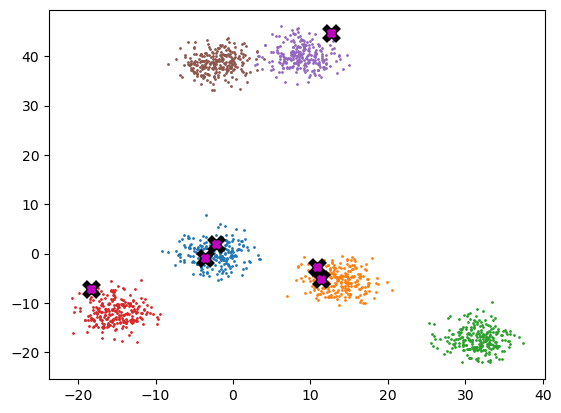

In [52]:
plot_data(init_centroids, data, n_samples)

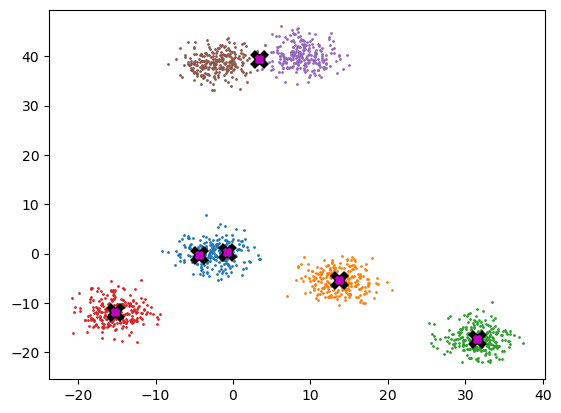

In [53]:
plot_data(final_centroids, data, n_samples)

We see that k-means has indeed converged, albeit not to an optimal solution.

## Animation

In [54]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [70]:
def do_one(d):
    global kmeans_centroids
    if d: kmeans_centroids = one_update(X, kmeans_centroids)
    ax.clear()
    plot_data(kmeans_centroids, X, n_samples, ax=ax)

In [71]:
random_indices = torch.randperm(data.size(0))[:n_clusters]
kmeans_centroids = data[random_indices]

fig, ax = plt.subplots()
ani= FuncAnimation(fig, do_one, frames=30, interval=500)
plt.close()
HTML(ani.to_jshtml())